# <span style="color:blue; font-weight:bold; text-decoration:underline;">Project Title: Rossmann Store Sales Prediction</span>

<h1 style="color:brown;"><u><b>Objective:</b></u></h1>

<p style="color:brown; font-weight:bold;">
The primary objective is to predict the sales for each store in the Rossmann chain for the next six weeks. 
This will involve analyzing historical sales data, store information, and external factors like promotions and holidays.
</p>

# <span style="color:brown"> Import Libraries</span>
```python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense

# <span style="color:brown"> Load the datasets with the specified file paths</span>
```python

In [52]:
import pandas as pd

train_df = pd.read_csv("C:\\Users\\DEEPA\\data\\PROJECT 6 SHEET\\train.csv", low_memory=False)
test_df = pd.read_csv("C:\\Users\\DEEPA\\data\\PROJECT 6 SHEET\\test.csv", low_memory=False)
store_df = pd.read_csv("C:\\Users\\DEEPA\\data\\PROJECT 6 SHEET\\Store.csv", low_memory=False)

In [53]:
# Load the datasets with the specified file paths
try:
    train_df = pd.read_csv(r"C:\Users\DEEPA\data\PROJECT 6 SHEET\train.csv", low_memory=False)
    test_df = pd.read_csv(r"C:\Users\DEEPA\data\PROJECT 6 SHEET\test.csv", low_memory=False)
    store_df = pd.read_csv(r"C:\Users\DEEPA\data\PROJECT 6 SHEET\Store.csv", low_memory=False)
    print("Datasets loaded successfully.")
except FileNotFoundError as e:
    print(f"Error: {e}. Please ensure the data directory and files exist.")
    exit()

Datasets loaded successfully.


In [54]:
# --- Data Cleaning and Merging ---
print("\nMerging dataframes...")
# Merge the train and test data with the store data based on 'Store' ID
train_merged = pd.merge(train_df, store_df, on='Store', how='left')
test_merged = pd.merge(test_df, store_df, on='Store', how='left')
print("Dataframes merged.")


Merging dataframes...
Dataframes merged.


In [55]:
# Drop rows in the training data where stores were closed (Open = 0) or had no sales
# We are only interested in predicting sales for open stores with actual sales
train_merged = train_merged[(train_merged['Open'] != 0) & (train_merged['Sales'] != 0)]

In [56]:
# --- Handle Missing Values ---
print("Handling missing values...")
# Fill missing CompetitionDistance with the median value
train_merged['CompetitionDistance'] = train_merged['CompetitionDistance'].fillna(train_merged['CompetitionDistance'].median())
test_merged['CompetitionDistance'] = test_merged['CompetitionDistance'].fillna(test_merged['CompetitionDistance'].median())

Handling missing values...


In [57]:
# Fill missing date-related features with 0
for col in ['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear']:
    train_merged[col] = train_merged[col].fillna(0)
    test_merged[col] = test_merged[col].fillna(0)

In [58]:
# Fill missing PromoInterval with a new category 'No_Promo'
train_merged['PromoInterval'] = train_merged['PromoInterval'].fillna('No_Promo')
test_merged['PromoInterval'] = test_merged['PromoInterval'].fillna('No_Promo')

In [59]:
# Fill missing 'Open' values in the test set, assuming missing means the store was open
test_merged['Open'] = test_merged['Open'].fillna(1)

In [60]:
print("Missing values handled.")

Missing values handled.


In [61]:
# --- Feature Engineering ---
print("Creating new features...")
# Convert the 'Date' column to a datetime object for easier manipulation
train_merged['Date'] = pd.to_datetime(train_merged['Date'], format='%d-%m-%Y')
test_merged['Date'] = pd.to_datetime(test_merged['Date'], format='%d-%m-%Y')

Creating new features...


In [62]:
# Extract time-based features from the 'Date' column
train_merged['Year'] = train_merged['Date'].dt.year
train_merged['Month'] = train_merged['Date'].dt.month
train_merged['Day'] = train_merged['Date'].dt.day
train_merged['WeekOfYear'] = train_merged['Date'].dt.isocalendar().week.astype(int)

test_merged['Year'] = test_merged['Date'].dt.year
test_merged['Month'] = test_merged['Date'].dt.month
test_merged['Day'] = test_merged['Date'].dt.day
test_merged['WeekOfYear'] = test_merged['Date'].dt.isocalendar().week.astype(int)

In [63]:
# Create a feature for how long the competition has been open (in months)
train_merged['CompetitionOpen'] = 12 * (train_merged['Year'] - train_merged['CompetitionOpenSinceYear']) + (train_merged['Month'] - train_merged['CompetitionOpenSinceMonth'])
train_merged['CompetitionOpen'] = train_merged['CompetitionOpen'].apply(lambda x: x if x > 0 else 0)

test_merged['CompetitionOpen'] = 12 * (test_merged['Year'] - test_merged['CompetitionOpenSinceYear']) + (test_merged['Month'] - test_merged['CompetitionOpenSinceMonth'])
test_merged['CompetitionOpen'] = test_merged['CompetitionOpen'].apply(lambda x: x if x > 0 else 0)

In [64]:
# Create a feature for how long Promo2 has been running (in weeks)
train_merged['Promo2Open'] = 52 * (train_merged['Year'] - train_merged['Promo2SinceYear']) + (train_merged['WeekOfYear'] - train_merged['Promo2SinceWeek'])
train_merged['Promo2Open'] = train_merged['Promo2Open'].apply(lambda x: x if x > 0 else 0)

test_merged['Promo2Open'] = 52 * (test_merged['Year'] - test_merged['Promo2SinceYear']) + (test_merged['WeekOfYear'] - test_merged['Promo2SinceWeek'])
test_merged['Promo2Open'] = test_merged['Promo2Open'].apply(lambda x: x if x > 0 else 0)


In [65]:
print("New features created.")

New features created.


In [66]:
# --- Exploratory Data Analysis (EDA) ---
print("\nStarting Exploratory Data Analysis (EDA)...")


Starting Exploratory Data Analysis (EDA)...


In [67]:
# Import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

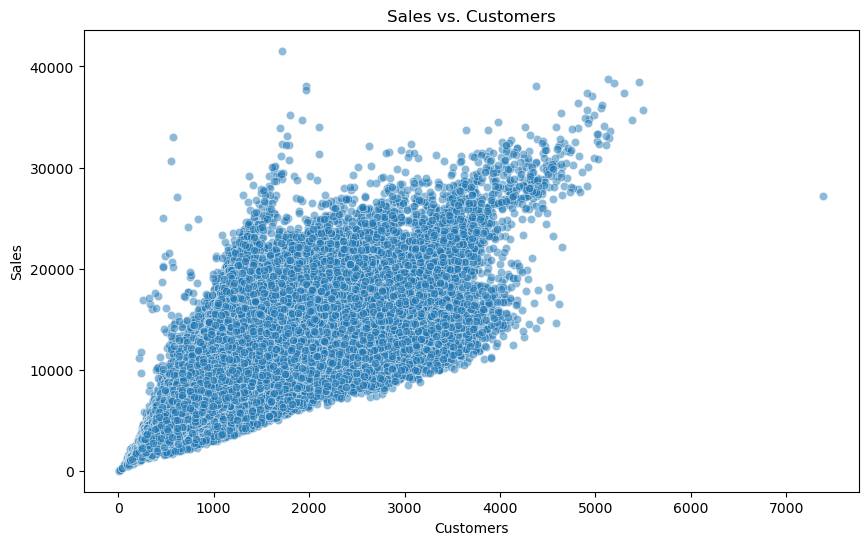

In [68]:
# Plot Sales vs. Customers
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Customers', y='Sales', data=train_merged, alpha=0.5)
plt.title('Sales vs. Customers')
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()

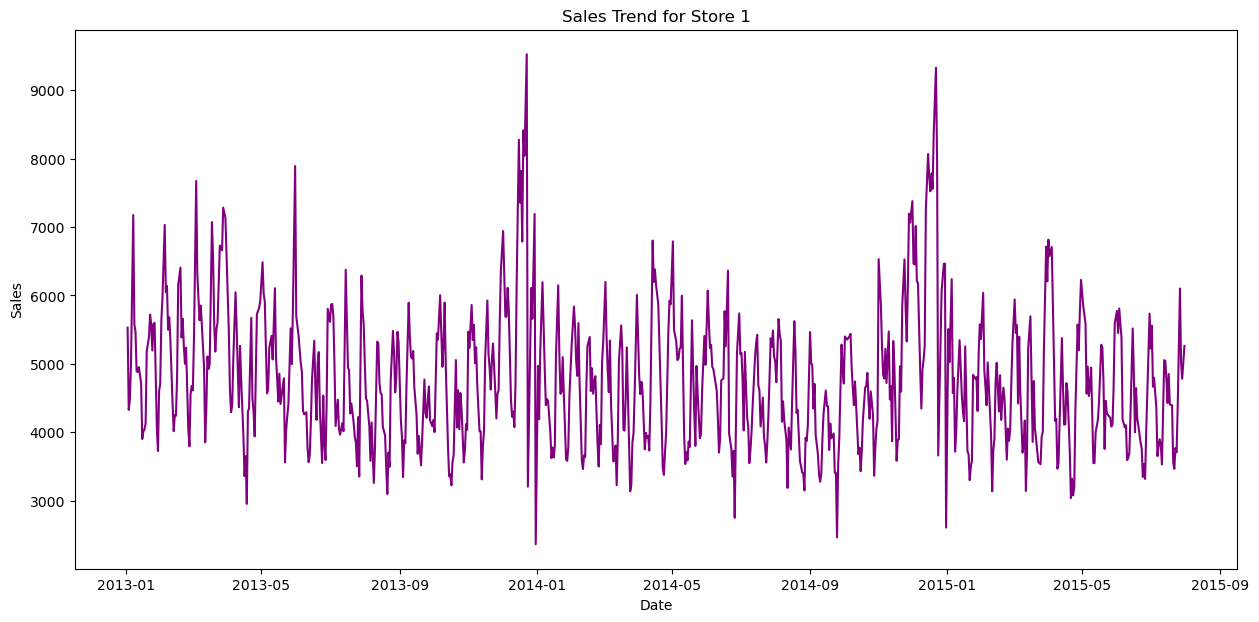

In [69]:
# Plot Sales trend over time for an example store (Store 1)
store1_df = train_merged[train_merged['Store'] == 1].sort_values('Date')
plt.figure(figsize=(15, 7))
plt.plot(store1_df['Date'], store1_df['Sales'], color='purple')
plt.title('Sales Trend for Store 1')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

In [70]:
print("EDA completed.")

EDA completed.


In [71]:
# --- Model Training Preparation ---
print("\nPreparing data for the model...")
# Define features and target variable
features_to_drop = ['Id', 'Date', 'Sales', 'Customers']
target = 'Sales'


Preparing data for the model...


In [72]:
# Handle categorical variables using one-hot encoding
categorical_cols = ['StoreType', 'Assortment', 'StateHoliday', 'PromoInterval']
train_processed = pd.get_dummies(train_merged, columns=categorical_cols, dummy_na=False)
test_processed = pd.get_dummies(test_merged, columns=categorical_cols, dummy_na=False)

In [73]:
# Align columns - crucial for ensuring the test set has the same features as the training set
train_labels = train_processed[target]
train_features = train_processed.drop(columns=features_to_drop, errors='ignore')
test_features = test_processed.drop(columns=['Id', 'Date'], errors='ignore') # test set has no 'Sales' or 'Customers'

In [74]:
# Align columns to ensure both dataframes have the same features
common_cols = list(set(train_features.columns) & set(test_features.columns))
train_features = train_features[common_cols]
test_features = test_features[common_cols]

In [75]:
print("Data preparation for training completed.")

Data preparation for training completed.


In [76]:
# --- Model Training ---
import xgboost as xgb
print("\nTraining the XGBoost model...")


Training the XGBoost model...


In [77]:
# Initialize the XGBoost Regressor model

model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

In [78]:
# Train the model
model.fit(train_features, train_labels)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=-1, num_parallel_tree=None, ...)

In [79]:
import joblib, os

save_path = r"C:\Users\DEEPA\data\PROJECT 6 SHEET\models"
if not os.path.exists(save_path):
    os.makedirs(save_path)

joblib.dump(model, os.path.join(save_path, "rossmann_model.pkl"))
print("Model saved successfully at:", os.path.join(save_path, "rossmann_model.pkl"))

Model saved successfully at: C:\Users\DEEPA\data\PROJECT 6 SHEET\models\rossmann_model.pkl


In [80]:
# Make predictions on the test data
test_preds = model.predict(test_features)

In [81]:
# Clamp predictions to be non-negative, as sales cannot be negative
test_preds[test_preds < 0] = 0

print("Model training and prediction completed.")

Model training and prediction completed.


In [82]:
# --- Save the Model ---
print("\nSaving the trained model...")


Saving the trained model...


In [83]:
# Save the model to a file using joblib
import joblib
model_filename = 'models/rossmann_model.pkl'
joblib.dump(model, model_filename)
print(f"Model saved as '{model_filename}'")

Model saved as 'models/rossmann_model.pkl'


In [84]:
# --- Create Submission File ---
print("\nCreating submission file...")


Creating submission file...


In [85]:
# Create a DataFrame with the correct Id from the original test data and our predictions
submission_df = pd.DataFrame({'Id': test_df['Id'], 'Sales': test_preds})

In [86]:
# Save the submission file to a CSV
submission_filename = 'submission.csv'
submission_df.to_csv(submission_filename, index=False)
print(f"Submission file saved as '{submission_filename}'")

Submission file saved as 'submission.csv'
